In [ ]:
# Google Colabにspm1dを追加でインストールする
!pip install spm1d

In [ ]:
# パッケージの読み込み
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as patches
import spm1d

---
### データ読み込み用関数の定義

In [ ]:
''' データ読み込み用関数 '''
#def importWaveData(file_list, skiprows=0, usecols=[0,1,2], smoothing=True, fwhm=1.0):
def importWaveData(file_list, skiprows=0, skipcols=0, smoothing=True, fwhm=1.0):

    # 解析用変数の用意
    Y = np.zeros((101,1))
        
    # 被験者ごとにループを回す
    for file_name in file_list:
        
        # 1被験者分を読み込む
        try:
            indivisual_data = np.genfromtxt(file_name, delimiter=',', skip_header=skiprows)
            indivisual_data = np.loadtxt(file_name, delimiter=',', skiprows=skiprows, usecols=list(range(skipcols, indivisual_data.shape[1])))
        except UnicodeDecodeError:
            indivisual_data = np.genfromtxt(file_name, delimiter=',', skip_header=skiprows, encoding='utf-8_sig')
            indivisual_data = np.loadtxt(file_name, delimiter=',', skiprows=skiprows, usecols=skipcols, encoding='utf-8_sig')
        
        # 代表波形（全試行の平均波形）を算出
        try:
            indivisual_data_mean = np.mean(indivisual_data, axis=1)
        except IndexError:
            indivisual_data_mean = indivisual_data

        # 測定時間の最大が100％になるように線形補間を行い
        indivisual_data_mean_interpolation = spm1d.util.interp(indivisual_data_mean, Q=101)
        
        # smoothing処理
        if smoothing==True:
            indivisual_data_mean_interpolation = spm1d.util.smooth(indivisual_data_mean_interpolation, fwhm=fwhm)
        
        # 1列のデータに成形しなおす
        indivisual_data_mean_interpolation = indivisual_data_mean_interpolation.reshape(101,1)
        
        # 解析用変数に格納する
        Y = np.concatenate([Y, indivisual_data_mean_interpolation], 1)
    
    # 余計な1列目を削除
    Y = np.delete(Y, obj=0, axis=1)
    
    # 転置させて、行が試行または被験者、列が時系列となるようにする
    Y = Y.T
    
    return Y


In [ ]:
''' One-way repeated-measures ANOVA用データ読み込み用関数 '''
def importWaveData_anova1RM(file_list, skiprows=0, usecols=[0,1,2], smoothing=True, fwhm=1.0):
    
    # 解析用変数の用意
    Y = np.zeros((1,101))
    A = np.zeros(0, dtype = int)
    SUBJ = np.zeros(0, dtype = int)
    
    # 被験者No変数（初期化）
    subjNo = 0

    # 被験者ごとにループを回す
    for file_name in file_list:
        
        # 1被験者分を読み込む
        try:
            indivisual_data = np.loadtxt(file_name, delimiter=',', skiprows=skiprows, usecols=usecols)
        except UnicodeDecodeError:
            indivisual_data = np.loadtxt(file_name, delimiter=',', skiprows=skiprows, usecols=usecols, encoding='utf-8_sig')

        # 以降の線形補間は列方向が時系列になっていないと処理できないため転置しておく
        indivisual_data = indivisual_data.T

        # 測定時間の最大が100％になるように線形補間を行う
        # 引数はリスト形式でないと各要素を処理できない
        indivisual_data_interpolation = spm1d.util.interp(indivisual_data.tolist(), Q=101)
        
        # smoothing処理
        if smoothing==True:
            indivisual_data_interpolation = spm1d.util.smooth(indivisual_data_interpolation, fwhm=fwhm)
                
        # 解析用変数に格納する
        numOfFactor = indivisual_data.shape[0]
        Y = np.concatenate([Y, indivisual_data_interpolation], 0)
        A = np.append(A, range(0, numOfFactor))
        SUBJ = np.append(SUBJ, [subjNo]*numOfFactor)

        # 被験者No+1
        subjNo += 1
    
    # 余計な1列目を削除
    Y = np.delete(Y, obj=0, axis=0)

    return Y, A, SUBJ

---
### 有意差のある区間の最初と最後を取得

In [ ]:
'''有意差区間の最初と最後のインデックスセットリストを取得するための関数'''
def getSigPeriods(tz, tizstar, two_tailed):

    # 統計処理結果から有意差のある区間のインデックスを取得
    if two_tailed:
        sig_time = np.where(abs(tz) >= tizstar)[0] # Trueの場合
    else:
        sig_time = np.where(tz >= tizstar)[0]      # Falseの場合

    # 有意差区間の最初と最後のインデックスセットを格納するための変数を用意
    sig_time_set = np.zeros(2).reshape(1,2)

    # 有意差区間が複数存在することを考慮して区間ごとのブロック単位で
    # インデックスセットを取得し、sig_time_setに順番に追加していく

    # 1ブロック分のインデックスを格納するための変数を用意
    tmpbrock = np.zeros(0)

    # sig_timeで取得されたインデックスを全て処理し終わるまでループを回す
    if len(sig_time) == 1:
        time_n = sig_time
        #time_n_plus1 = sig_time
        tmpbrock = np.append(tmpbrock, time_n)
        tmpset = np.array([tmpbrock[0], tmpbrock[-1]]).reshape(1,2)
        sig_time_set = np.concatenate([sig_time_set, tmpset], 0)
    else:
        for i in range(0,len(sig_time)):
            try:
                time_n = sig_time[i]
                time_n_plus1 = sig_time[i+1] # sig_timeの最後のインデックスでは+1されたデータは
                                            # そもそも存在しないため、エラーとなる。
                                            # 存在しないことがわかっているエラーであるため
                                            # 例外処理でエラーを回避する
            except:
                pass

            if (time_n+1)==time_n_plus1:
                # +1されたデータが存在しなくなるまでtmpbrockにインデックスを追加し続ける
                tmpbrock = np.append(tmpbrock, time_n)
            else:
                tmpbrock = np.append(tmpbrock, time_n)

                # 1ブロック分完成　→　最初と最後のインデックスのみ取得し、1行2列に成形
                tmpset = np.array([tmpbrock[0], tmpbrock[-1]]).reshape(1,2)

                # sig_time_setの行方向にtmpsetを追加
                sig_time_set = np.concatenate([sig_time_set, tmpset], 0)

                # 次のブロックのインデックスを取得するため、tmpbrockを初期化
                tmpbrock = np.zeros(0)

    # 1行目に余計なデータが残っているので削除
    sig_time_set = sig_time_set[1:,].astype(int)

    return sig_time_set


---
### 統計解析・グラフ化とファイル出力

In [ ]:
'''指定したグラフの見た目を調整する関数'''
# 統計手法によってグラフの見た目調整は異なるが、その中でも共通項目はこの関数でまとめて実行する
# 共通項目以外の調整は、この関数を実行後に統計手法に合わせて追加の調整を行う

def modifyGraph(ylabel, SPMinference):

    plt.xlim(0, 101)                                       # x軸範囲指定

    plt.hlines(0, 0, 100, color='k', linestyles='-', lw=1) # y=0の実線を追加

    plt.gca().spines['right'].set_visible(False)           # 右縦軸を非表示
    plt.gca().spines['top'].set_visible(False)             # 上横軸を非表示
    plt.gca().spines['bottom'].set_visible(False)          # 下横軸を非表示

    plt.gca().spines['bottom'].set_position(('data', 0))   # y軸とx軸の交点を(0,0)に設定

    plt.xticks(fontsize=0)                                 # x軸目盛りを非表示
    plt.yticks(fontsize=14)                                # y軸目盛りのフォントサイズ変更
    
    plt.grid(linestyle='dashed', linewidth=0.5)            # グリッドを表示


In [ ]:
''' resampling wave dataのcsv保存関数 '''
def saveResamplingWaveData(stats, x, outputFileName, labels, nowTime):
    # stats : 統計手法　'ttest', 'ttest_paired', 'ttest2', 'anova1', 'anova1rm'
    # x : resampling wave data（outputGraph関数を参照）
    # labels : groupごとのラベルをリストで与える→['group_A', 'group_B']など、1群のみのときもリスト化
    # outputFileName : 出力ファイルに追加する名前

    # 書き込み用のファイルを準備
    f = open('resample_data_' + stats + '_' + outputFileName + '_' + nowTime + '.csv', 'w')

    number = 1

    # 1群解析
    if any([stats==i for i in ['ttest']]):

        # 列名のリストを作成
        col_names_list = labels*x[0].shape[0]

        # 列名にナンバリング付与
        for tmp_col in col_names_list:
            col_names_list[number-1] = tmp_col + '_{:03}'.format(number)
            number += 1
        
        # リストを文字列に変換（カンマ区切り）
        col_names_str = ','.join(col_names_list)

        # 追記
        f.write(col_names_str + '\n')

        Y = x[0]

    # 2群解析
    elif any([stats==i for i in ['ttest_paired', 'ttest2']]):

        # 列名のリストを作成
        col_names_list1 = [labels[0]]*x[0].shape[0]
        col_names_list2 = [labels[1]]*x[1].shape[0]

        # 列名にナンバリング付与
        for tmp_col in col_names_list1:
            col_names_list1[number-1] = tmp_col + '_{:03}'.format(number)
            number += 1

        number = 1

        for tmp_col in col_names_list2:
            col_names_list2[number-1] = tmp_col + '_{:03}'.format(number)
            number += 1

        # リストを文字列に変換（カンマ区切り）
        col_names_str1 = ','.join(col_names_list1)
        col_names_str2 = ','.join(col_names_list2)

        # 追記
        f.write(col_names_str1 + ',' + col_names_str2 + '\n')

        Y = np.concatenate([x[0], x[1]], 0)

    # 3群解析
    elif any([stats==i for i in ['anova1']]):

        # 列名のリストを作成
        col_names_list1 = [labels[0]]*x[0].shape[0]
        col_names_list2 = [labels[1]]*x[1].shape[0]
        col_names_list3 = [labels[2]]*x[2].shape[0]

        # 列名にナンバリング付与
        for tmp_col in col_names_list1:
            col_names_list1[number-1] = tmp_col + '_{:03}'.format(number)
            number += 1

        number = 1

        for tmp_col in col_names_list2:
            col_names_list2[number-1] = tmp_col + '_{:03}'.format(number)
            number += 1

        number = 1

        for tmp_col in col_names_list3:
            col_names_list3[number-1] = tmp_col + '_{:03}'.format(number)
            number += 1

        # リストを文字列に変換（カンマ区切り）
        col_names_str1 = ','.join(col_names_list1)
        col_names_str2 = ','.join(col_names_list2)
        col_names_str3 = ','.join(col_names_list3)

        # 追記
        f.write(col_names_str1 + ',' + col_names_str2 + ',' + col_names_str3 + '\n')

        Y = np.concatenate([x[0], x[1], x[2]], 0)

    # 反復測定解析　'anova1rm'
    elif any([stats==i for i in ['anova1rm']]):

        A = x[1]         # 繰り返し測定回数はひとまず8回を上限（これを超える場合は要相談）
        SUBJ = x[2]

        # Subjectにナンバリング付与
        SUBJ_list = []
        for tmp_subj in SUBJ:
            SUBJ_list.append('Subject_{:03}'.format(tmp_subj))

        # 繰り返し回にナンバリング付与
        A_list = []
        for tmp_A in A:
            A_list.append('times_{:02}'.format(tmp_A))

        # リストを文字列に変換（カンマ区切り）
        SUBJ_str = ','.join(SUBJ_list)
        A_str = ','.join(A_list)

        # 追記
        f.write(SUBJ_str + '\n')
        f.write(A_str + '\n')

        Y = x[0]

    # resampling wave data をカンマ区切りテキストとしてファイルに追記
    for one_point_wave_data in Y.T:
        write_wave_data = ','.join(map(str, one_point_wave_data.tolist()))
        write_wave_data = write_wave_data.replace('[', '')
        write_wave_data = write_wave_data.replace(']', '')
        f.write(write_wave_data + '\n')

    # ファイルを閉じて保存
    f.close()


In [ ]:
'''統計処理・グラフ化関数'''
def outputGraph(stats, x, labels, ylabel, SPM, SPMinference, SPMrm=None, SPMinferencerm=None, legend_anova1rm=None, outputFileName=None, figForm='png', two_tailed=False):
    # stats : 統計手法　'ttest', 'ttest_paired', 'ttest2', 'anova1', 'anova1rm'
    # x : groupごとのデータをリストで与える→[group_A, group_B]など、1群のみのときもリスト化
    # labels : groupごとのラベルをリストで与える→['group_A', 'group_B']など、1群のみのときもリスト化
    # ylabel : 源波形グラフのY軸ラベル
    # SPM : 統計解析結果　→　t or F を与える
    # SPMinference : 統計解析結果　→　ti or Fi を与える
    # SPMrm : 反復測定の統計解析結果　→　Frm を与える
    # SPMinferencerm : 反復測定の統計解析結果　→　Firm を与える
    # legend_anova1rm : anova1rmを利用する際に上段グラフに表示する凡例リストを与える
    # outputFileName : 出力ファイルに追加する名前
    # figForm : 対応画像形式： eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

    # get time - ファイル保存時の名前に利用
    dt_now = datetime.datetime.now()
    nowTime = dt_now.strftime('%Y%m%d%H%M')

    # 図全体の幅と高さをインチで指定する
    fig = plt.figure(figsize=(7,7))

    # グラフ描画の大枠を作成
    gs0 = GridSpec(2, 1, height_ratios=[1, 2]) # 上下2段で高さの割合を上から1:2にする

    gs00 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0]) # 上段は源波形を描画
    gs01 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1]) # 下段は統計結果波形と有意差提示ブロックを描画
                                                              # 実質、上・中・下の三段となる
                                                              # わざわざこのように分割しているのは有意差提示ブロックの
                                                              # 高さが狭くなるようにするため

    '''上段（源波形）の描画'''
    # 上段プロットエリアを作製
    plt.subplot(gs00[0, 0])

    # 1群解析
    if any([stats==i for i in ['ttest']]):
        Y = x[0]
        spm1d.plot.plot_mean_sd(Y, lw=1.5, linecolor='k', linestyle='-', facecolor=(0.7,0.7,1), edgecolor='k', label=labels[0])

        modifyGraph(ylabel, SPMinference)
        plt.ylabel(ylabel, size=14)
        plt.legend(fontsize=13)

        # save csv
        saveResamplingWaveData(stats, x, outputFileName, labels, nowTime)

    # 2群解析
    elif any([stats==i for i in ['ttest_paired', 'ttest2']]):
        Y0 = x[0]
        Y1 = x[1]
        spm1d.plot.plot_mean_sd(Y0, lw=1.5, linecolor='k', linestyle='-', facecolor=(0.7,0.7,1), edgecolor='k', label=labels[0])
        spm1d.plot.plot_mean_sd(Y1, lw=2.5, linecolor='k', linestyle=':', facecolor=(0.7,0.7,1), edgecolor='k', label=labels[1])

        modifyGraph(ylabel, SPMinference)
        plt.ylabel(ylabel, size=14)
        plt.legend(fontsize=13)

        # save csv
        saveResamplingWaveData(stats, x, outputFileName, labels, nowTime)

    # 3群解析
    elif any([stats==i for i in ['anova1']]):
        Y0 = x[0]
        Y1 = x[1]
        Y2 = x[2]
        spm1d.plot.plot_mean_sd(Y0, lw=1.5, linecolor='k', linestyle='-',  facecolor=(0.7,0.7,1), edgecolor='k', label=labels[0])
        spm1d.plot.plot_mean_sd(Y1, lw=2.5, linecolor='k', linestyle=':',  facecolor=(0.7,0.7,1), edgecolor='k', label=labels[1])
        spm1d.plot.plot_mean_sd(Y2, lw=2.0, linecolor='k', linestyle='-.', facecolor=(0.7,0.7,1), edgecolor='k', label=labels[2])

        modifyGraph(ylabel, SPMinference)
        plt.ylabel(ylabel, size=14)
        plt.legend(fontsize=13)

        # save csv
        saveResamplingWaveData(stats, x, outputFileName, labels, nowTime)

    # 反復測定解析　'anova1rm'
    elif any([stats==i for i in ['anova1rm']]):
        Y = x[0]
        A = x[1]         # 繰り返し測定回数はひとまず8回を上限（これを超える場合は要相談）
        SUBJ = x[2]
        color_set = ['b','k','r','c','m','y','g','w']
        legend_set = [0, 0, 0, 0, 0, 0, 0, 0]
        each_factor = np.unique(A)
        for i in range(0, len(each_factor)):
            plt.plot(Y[A==each_factor[i]].T, color_set[i])
            legend_set[i] = plt.plot(Y[A==each_factor[i]].T, color_set[i])
        
        modifyGraph(ylabel, SPMinference)
        plt.ylabel(ylabel, size=14)
        plt.legend([legend_set[0][0], legend_set[1][0], legend_set[2][0]], legend_anova1rm, fontsize=12)
        # legendカスタマイズは以下を参考
        # Customize Python legend
        # https://stackoverflow.com/questions/53230713/customize-python-legend

        # save csv
        saveResamplingWaveData(stats, x, outputFileName, labels, nowTime)

    # その他
    else:
        pass

    '''中段（統計解析結果波形）の描画'''
    # 中段プロットエリアを作製
    plt.subplot(gs01[0, 0])

    # 1元配置分散分析　'anova1'
    if any([stats==i for i in ['anova1']]):
        SPMinference.plot()

        modifyGraph(ylabel, SPMinference)
        plt.ylim(-90, 500)
        F_text = '$F^*$=%.3f' % (SPMinference.zstar)     # 有意となる統計量を表示
        plt.text(100, SPMinference.zstar*1.2, F_text, horizontalalignment='right', size=14)

        # save csv
        np.savetxt('stat_data_' + stats + '_' + outputFileName + '_' + nowTime + '.csv', SPM.z, delimiter=',', fmt='%.18f')

    # 反復測定解析　'anova1rm'
    elif any([stats==i for i in ['anova1rm']]):
        SPMinferencerm.plot(color='r', facecolor=(0.8,0.3,0.3), label='Within-subjects analysis')
        SPMinference.plot(label='Between-subjects analysis')

        modifyGraph(ylabel, SPMinference)
        plt.ylim(-4, )
        plt.legend(fontsize=11)
        F_text = '$F^*$=%.3f' % (SPMinference.zstar)     # 有意となる統計量を表示
        plt.text(100, SPMinference.zstar*1.2, F_text, horizontalalignment='right', size=14)

        # save csv
        np.savetxt('stat_data_' + stats + '_' + outputFileName + '_Between-subjects analysis_' + nowTime + '.csv', SPM.z, delimiter=',', fmt='%.18f')
        np.savetxt('stat_data_' + stats + '_' + outputFileName + '_Within-subjects analysis_' + nowTime + '.csv', SPMrm.z, delimiter=',', fmt='%.18f')

    # 上記以外の統計手法の場合
    else:
        SPMinference.plot()

        modifyGraph(ylabel, SPMinference)
        t_text = '$t^*$=%.3f' % (SPMinference.zstar)     # 有意となる統計量を表示
        plt.text(100, SPMinference.zstar*1.2, t_text, horizontalalignment='right', size=14)

        # save csv
        np.savetxt('stat_data_' + stats + '_' + outputFileName + '_' + nowTime + '.csv', SPM.z, delimiter=',', fmt='%.18f')

    '''下段（統計解析結果波形）の描画'''
    # 下段プロットエリアを作製
    plt.subplot(gs01[1, 0])

    plt.xlim(0, 101) # 上・中段グラフとx軸のスケールを合わせる
    plt.axis("off")  # 軸を全て非表示にする

    # 長方形を作製・描画
    rectangle_form = patches.Rectangle(xy=(0, 0.7), width=100, height=0.3, lw=1, ec='#000000', fill=False)
    plt.gca().add_patch(rectangle_form)

    # 軸と目盛りラベルをマニュアルで追加
    plt.text(0, 0.55, '0', horizontalalignment='center', size=14)
    plt.text(100, 0.55, '100', horizontalalignment='center', size=14)
    plt.text(50, 0.50, 'Time (%)', horizontalalignment='center', size=14)

    # 有意差区間インデックスのセットリストを取得
    sig_time_set = getSigPeriods(SPM.z, SPMinference.zstar, two_tailed)

    # 有意差区間を塗り潰して数値を追記
    for index_set in sig_time_set:
        plt.axvspan(index_set[0], index_set[1]+0.5, 0.7, 1.0, color = 'k')
        plt.text(index_set[0], 0.60, '{:d}'.format(index_set[0]), horizontalalignment='center', verticalalignment='bottom', size=12)
        plt.text(index_set[1]+0.5, 1.10, '{:d}'.format(index_set[1]), horizontalalignment='center', verticalalignment='top',  size=12)

    # save csv
    np.savetxt('significant_TimePercent_' + stats + '_' + outputFileName + '_' + nowTime + '.csv', sig_time_set, delimiter=',', fmt='%d')

    # レイアウト修正・最終描画
    plt.tight_layout()
    fig.show()

    # save fig
    fileName_fig = './fig_' + stats + '_' + outputFileName + '_' + nowTime + '.' + figForm
    fig.savefig(fileName_fig)

---
## まとめて実行

In [ ]:
def autoSPM1d(stats, file_list1=None, file_list2=None, file_list3=None, skiprows=0, skipcols=0, smoothing=True, fwhm=2.5, alpha=0.05, two_tailed=False, interp=True, equal_var=True, labels='group', ylabel=r'$\theta$ (deg)', legend_anova1rm=None, outputFileName=None, figForm='png'):
    # stats : 統計手法　'ttest', 'ttest_paired', 'ttest2', 'anova1', 'anova1rm'
    # file_list1 : 解析したいファイル名（相対または絶対パス）をリストで渡す　→　必須
    # file_list2 : 異なる群の解析したいファイル名（相対または絶対パス）をリストで渡す　→　'ttest_paired', 'ttest2', 'anova1'
    # file_list3 : 異なる群の解析したいファイル名（相対または絶対パス）をリストで渡す　→　'anova1'
    # skiprows : 読み込むファイルにヘッダーや列名が含まれる場合はスキップする行数を指定
    # usecols : 読み込むファイルに行名や処理から除外したい列がある場合は、処理したい列をリストで渡す
    # smoothing : 時間を100％にリサンプリングした後、スムージングをかけるかどうか指定
    # fwhm : スムージングの強さを指定
    # alpha : 有意水準の指定
    # two_tailed : 両側検定にするかどうか指定
    # interp : クラスタを臨界閾値に補間するかどうか指定
    # labels : groupごとのラベルをリストで与える→['group_A', 'group_B']など、1群のみのときもリスト化
    # ylabel : 源波形グラフのY軸ラベル
    # legend_anova1rm : anova1rmを利用する際に上段グラフに表示する凡例リストを与える
    # outputFileName : 出力ファイルに追加する名前
    # figForm : 対応画像形式： eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

    # 1群解析
    if any([stats==i for i in ['ttest']]):
        group = importWaveData(file_list1, skiprows=skiprows, skipcols=skipcols, smoothing=smoothing, fwhm=fwhm)
        x = [group]

        # One-sample t test
        if stats=='ttest':
            mu = 0 #mu is 0 by default
            SPM  = spm1d.stats.ttest(group, mu)
            SPMinference = SPM.inference(alpha=alpha, two_tailed=two_tailed, interp=interp) # two_tailed=False, interp=True

            outputGraph(stats, x, labels, ylabel, SPM, SPMinference, outputFileName=outputFileName, figForm=figForm, two_tailed=two_tailed)

    # 2群解析
    elif any([stats==i for i in ['ttest_paired', 'ttest2']]):
        group_A = importWaveData(file_list1, skiprows=skiprows, skipcols=skipcols, smoothing=smoothing, fwhm=fwhm)
        group_B = importWaveData(file_list2, skiprows=skiprows, skipcols=skipcols, smoothing=smoothing, fwhm=fwhm)
        x = [group_A, group_B]

        # Paired t test
        if stats=='ttest_paired':
            SPM  = spm1d.stats.ttest_paired(group_A, group_B)
            SPMinference = SPM.inference(alpha=alpha, two_tailed=two_tailed) # two_tailed=True

            outputGraph(stats, x, labels, ylabel, SPM, SPMinference, outputFileName=outputFileName, figForm=figForm, two_tailed=two_tailed)
        
        # Two-sample t test
        elif stats=='ttest2':
            SPM  = spm1d.stats.ttest2(group_A, group_B, equal_var=equal_var) # equal_var=True
            SPMinference = SPM.inference(alpha=alpha, two_tailed=two_tailed, interp=interp) # two_tailed=True, interp=True

            outputGraph(stats, x, labels, ylabel, SPM, SPMinference, outputFileName=outputFileName, figForm=figForm, two_tailed=two_tailed)

    # 3群解析
    elif any([stats==i for i in ['anova1']]):
        group_A = importWaveData(file_list1, skiprows=skiprows, skipcols=skipcols, smoothing=smoothing, fwhm=fwhm)
        group_B = importWaveData(file_list2, skiprows=skiprows, skipcols=skipcols, smoothing=smoothing, fwhm=fwhm)
        group_C = importWaveData(file_list3, skiprows=skiprows, skipcols=skipcols, smoothing=smoothing, fwhm=fwhm)
        x = [group_A, group_B, group_C]

        # One-way ANOVA
        if stats=='anova1':
            SPM  = spm1d.stats.anova1( (group_A,group_B,group_C), equal_var=equal_var) # equal_var=False
            SPMinference = SPM.inference(alpha=alpha, interp=interp) # interp=True

            outputGraph(stats, x, labels, ylabel, SPM, SPMinference, outputFileName=outputFileName, figForm=figForm, two_tailed=two_tailed)

    # 'anova1rm'
    # One-way repeated-measures ANOVA
    elif any([stats==i for i in ['anova1rm']]):
        Y, A, SUBJ = importWaveData_anova1RM(file_list1, skiprows=skiprows, usecols=skipcols, smoothing=smoothing, fwhm=fwhm)
        x = [Y, A, SUBJ]

        SPM            = spm1d.stats.anova1(Y, A, equal_var) # equal_var = True
        SPMrm          = spm1d.stats.anova1rm(Y, A, SUBJ, equal_var)
        SPMinference   = SPM.inference(alpha)
        SPMinferencerm = SPMrm.inference(alpha)

        outputGraph(stats, x, labels, ylabel, SPM, SPMinference, SPMrm=SPMrm, SPMinferencerm=SPMinferencerm, legend_anova1rm=legend_anova1rm, outputFileName=outputFileName, figForm=figForm, two_tailed=two_tailed)

    # その他
    else:
        pass



### autoSPM1d関数 使い方
```
autoSPM1d(stats,                     # 統計手法選択　'ttest', 'ttest_paired', 'ttest2', 'anova1', 'anova1rm'
          file_list1=None,           # 入力csvファイルのパスをリスト形式で与える（全統計手法で必須）
          file_list2=None,           # 同上（2群解析の統計手法で必須）
          file_list3=None,           # 同上（3群解析の統計手法で必須）
          skiprows=0,                # 入力csvファイルでスキップする行数を指定（列ラベルなどがなければ省略可）
          usecols=[0,1,2],           # 入力csvファイルでスキップする列数を指定（行ラベルなどがなければ省略可）
          smoothing=True,            # 平滑化処理を行うかどうか指定（デフォルトはTrueで省略可）
          fwhm=2.5,                  # 平滑化処理のパラメータ（デフォルトは2.5で省略可）
          alpha=0.05,                # 有意水準の指定（デフォルトは0.05で省略可）
          two_tailed=False,          # 両側検定かどうか指定（デフォルトはFalseで省略可）
          interp=True,               # クラスタを臨界閾値に補間するかどうか指定（デフォルトはTrueで省略可、SPM1dのマニュアルを参照ください）
          equal_var=True,            # 等分散を仮定するかどうか指定（デフォルトはTrueで省略可）
          labels='group',            # groupごとのラベルをリストで与える→['group_A', 'group_B']など
          ylabel=r'$\theta$ (deg)',  # 源波形グラフ（上段）のY軸ラベル（デフォルトはr'$\theta$ (deg)'で省略可）
          legend_anova1rm=None,      # anova1rmを利用する際に上段グラフに表示する凡例のリストを指定（anova1rm以外では省略可）
          outputFileName=None,       # 出力ファイルに追加する名前（省略可）
          figForm='png'              # 対応画像形式： eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff（デフォルトはpngで省略可）
          )
```

In [ ]:
# データセット
file_list_A = np.array(['SPMsub1_A.csv',
                        'SPMsub2_A.csv',
                        'SPMsub3_A.csv'])

file_list_B = np.array(['SPMsub1_B.csv',
                        'SPMsub2_B.csv',
                        'SPMsub3_B.csv'])

file_list_C = np.array(['SPMsub1_C.csv',
                        'SPMsub2_C.csv',
                        'SPMsub3_C.csv'])

---
### One-sample t test

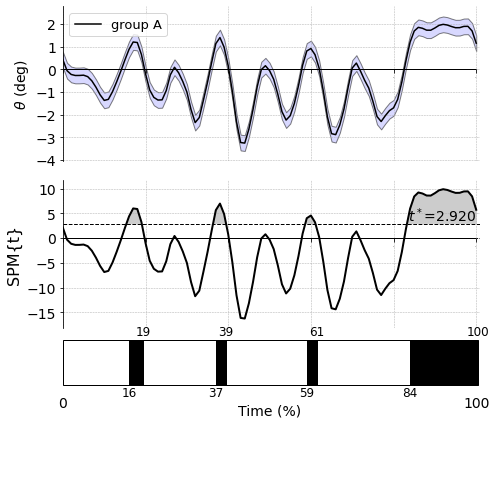

In [ ]:
autoSPM1d('ttest', file_list1=file_list_A, skiprows=0, skipcols=1, 
          smoothing=True, fwhm=2.5, 
          alpha=0.05, two_tailed=False, interp=True,
          labels=['group A'], ylabel=r'$\theta$ (deg)',
          outputFileName='', figForm='png')

---
### Paired t test

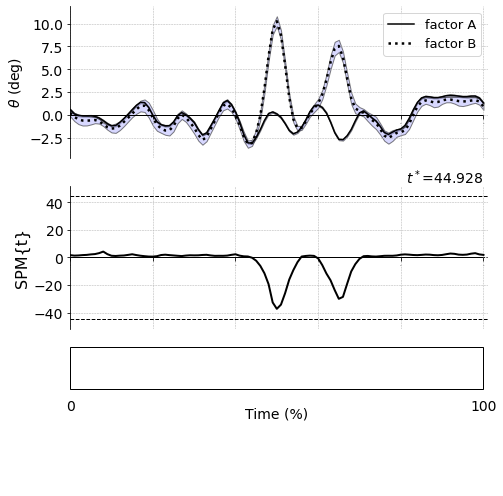

In [ ]:
autoSPM1d('ttest_paired', file_list1=file_list_A, file_list2=file_list_B, skiprows=0, skipcols=1, 
          smoothing=True, fwhm=2.5, 
          alpha=0.05, two_tailed=True, 
          labels=['factor A', 'factor B'], ylabel=r'$\theta$ (deg)',
          outputFileName='', figForm='png')

---
### Two-sample t test

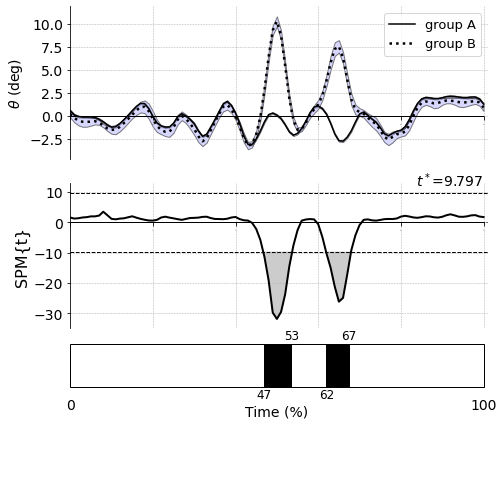

In [ ]:
autoSPM1d('ttest2', file_list1=file_list_A, file_list2=file_list_B, skiprows=0, skipcols=1, 
          smoothing=True, fwhm=2.5, 
          alpha=0.05, two_tailed=True, interp=True, equal_var=True, 
          labels=['group A', 'group B'], ylabel=r'$\theta$ (deg)',
          outputFileName='', figForm='png')

---
### One-way ANOVA

<ipython-input-158-c4cc649c213d>:61: UserWarning: 

  SPM  = spm1d.stats.anova1( (group_A,group_B,group_C), equal_var=equal_var) # equal_var=False


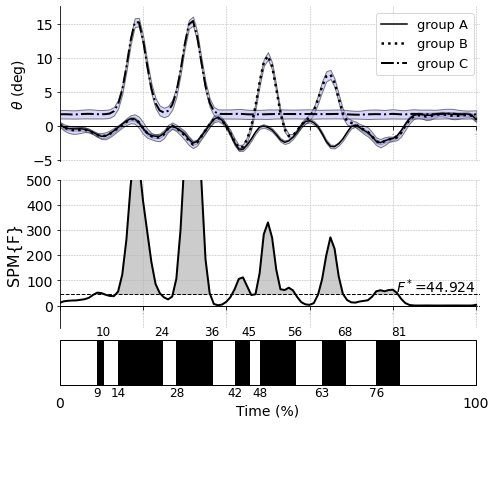

In [ ]:
autoSPM1d('anova1', file_list1=file_list_A, file_list2=file_list_B, file_list3=file_list_C, skiprows=0, skipcols=1, 
          smoothing=True, fwhm=2.5, 
          alpha=0.05, interp=True, equal_var=False, 
          labels=['group A', 'group B', 'group C'], ylabel=r'$\theta$ (deg)',
          outputFileName='', figForm='png')

---
### One-way repeated-measures ANOVA

/usr/local/lib/python3.8/dist-packages/spm1d/stats/anova/ui.py:118: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


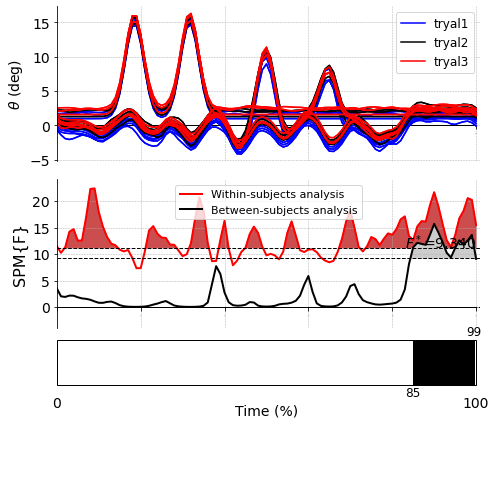

In [ ]:
file_list_anova1rm = np.array(['SPMsub1_A.csv',
                               'SPMsub2_A.csv',
                               'SPMsub3_A.csv',
                               'SPMsub1_B.csv',
                               'SPMsub2_B.csv',
                               'SPMsub3_B.csv',
                               'SPMsub1_C.csv',
                               'SPMsub2_C.csv',
                               'SPMsub3_C.csv'])

autoSPM1d('anova1rm', file_list1=file_list_anova1rm, skiprows=0, skipcols=[1,2,3], 
          smoothing=True, fwhm=2.5, 
          alpha=0.05, equal_var=True, 
          ylabel=r'$\theta$ (deg)', legend_anova1rm=['tryal1', 'tryal2', 'tryal3'],
          outputFileName='', figForm='png')